<a href="https://colab.research.google.com/github/1489685175z-coder/Bird_Speicy_Classification/blob/main/Bird_Speicy_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Project: Fine-Grained Bird Species Classification on CUB-200-2011
# Compare: Pretrained ResNet-18 vs Pretrained ViT

# =============================================================================
# 1. Install dependencies (if needed in Colab)
# =============================================================================
!pip install -q transformers datasets torch torchvision scikit-learn matplotlib pillow tqdm evaluate
!pip install seaborn
# =============================================================================
# 2. Import libraries
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from transformers import ViTForImageClassification
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd

In [2]:
# =============================================================================
# 3. Device & Hyperparameters
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 32  # Compromise between originals (16 for ViT, 64 for ResNet)
NUM_EPOCHS = 30   # Balanced for comparison
NUM_CLASSES = 200

models_config = [
    {"name": "resnet18", "pretrained": True, "lr": 0.001},
    {"name": "vit", "pretrained": True, "lr": 3e-5}
]


Using device: cuda


In [3]:
# =============================================================================
# 4. Load Dataset from Hugging Face
# =============================================================================
print("Loading dataset...")
hf_dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")

class_names = hf_dataset['train'].features['label'].names  # Get class names for reporting

class CUBDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert('RGB')
        label = item['label']
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_ds = CUBDataset(hf_dataset['train'], train_transform)
test_ds = CUBDataset(hf_dataset['test'], test_transform)

train_size = int(0.85 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}, Test samples: {len(test_ds)}")
print(f"Num classes: {NUM_CLASSES}, Example classes: {class_names[:5]}...")


Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train samples: 5094, Val samples: 900, Test samples: 5794
Num classes: 200, Example classes: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet']...


In [4]:
# =============================================================================
# 5. Train and Evaluate Functions (Unified for both models)
# =============================================================================
def train_epoch(model, loader, criterion, optimizer, scaler, device, model_name):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            if model_name == "vit":
                outputs = model(pixel_values=images).logits
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += images.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device, model_name, is_test=False):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_logits = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            if model_name == "vit":
                outputs = model(pixel_values=images).logits
            else:
                outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += images.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if is_test:
                all_logits.extend(outputs.cpu().numpy())  # For top-5
    acc = correct / total
    loss = total_loss / total
    top5_acc = top_k_accuracy_score(all_labels, all_logits, k=5) if is_test else None
    return loss, acc, top5_acc, all_preds, all_labels


In [5]:
# =============================================================================
# 6. Main Training Loop
# =============================================================================
all_history = {}
test_results = {}
for config in models_config:
    name = config["name"]
    print(f"\n=== Training {name} ===")
    if name == "resnet18":
        model = models.resnet18(pretrained=config["pretrained"])
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
        # Freeze all except last layer and classifier (as in original ResNet)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True

    elif name == "vit":
        model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k",
            num_labels=NUM_CLASSES,
            ignore_mismatched_sizes=True
        )
        # No freezing in original ViT, so train all with small LR

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=0.01)
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "train_time": []}
    best_val_acc = 0.0
    t_start = time.time()

    for epoch in range(NUM_EPOCHS):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device, name)
        va_loss, va_acc, _, _, _ = evaluate(model, val_loader, criterion, device, name)
        scheduler.step(va_acc)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        epoch_time = time.time() - t_start
        history["train_time"].append(epoch_time)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            torch.save(model.state_dict(), f"best_{name}.pth")

    total_train_time = time.time() - t_start
    print(f"Total training time for {name}: {total_train_time:.1f}s")

    # Load best model for test
    model.load_state_dict(torch.load(f"best_{name}.pth", map_location=device))
    te_loss, te_acc, te_top5_acc, te_preds, te_labels = evaluate(model, test_loader, criterion, device, name, is_test=True)
    report = classification_report(te_labels, te_preds, target_names=class_names, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']

    test_results[name] = {
        "acc": te_acc,
        "top5_acc": te_top5_acc,
        "macro_f1": macro_f1,
        "train_time": total_train_time,
        "preds": te_preds,
        "labels": te_labels
    }
    all_history[name] = history

    # Per-model error analysis (top-5 confused pairs)
    errors = [(true, pred) for true, pred in zip(te_labels, te_preds) if true != pred]
    if errors:
        most_common_errors = Counter(errors).most_common(5)
        print(f"Top 5 confused pairs for {name} (True → Predicted):")
        for (true_label, pred_label), count in most_common_errors:
            true_name = class_names[true_label]
            pred_name = class_names[pred_label]
            print(f"  {true_name} → {pred_name} : {count} times")


=== Training resnet18 ===


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-3482151153.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
Training:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipython-input-838357888.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

Epoch 1/30 | Train Loss: 4.4234 Acc: 0.1264 | Val Loss: 3.8186 Acc: 0.1956


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.07it/s]


Epoch 2/30 | Train Loss: 3.3613 Acc: 0.2925 | Val Loss: 3.1834 Acc: 0.3367


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.21it/s]


Epoch 3/30 | Train Loss: 2.9623 Acc: 0.4099 | Val Loss: 3.1553 Acc: 0.3911


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


Epoch 4/30 | Train Loss: 2.7525 Acc: 0.4707 | Val Loss: 2.9754 Acc: 0.4111


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.17it/s]


Epoch 5/30 | Train Loss: 2.5678 Acc: 0.5228 | Val Loss: 2.9548 Acc: 0.4311


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.34it/s]


Epoch 6/30 | Train Loss: 2.4708 Acc: 0.5503 | Val Loss: 2.9138 Acc: 0.4433


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.33it/s]


Epoch 7/30 | Train Loss: 2.3618 Acc: 0.5883 | Val Loss: 2.9127 Acc: 0.4556


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.22it/s]


Epoch 8/30 | Train Loss: 2.2979 Acc: 0.6139 | Val Loss: 2.8062 Acc: 0.4822


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.19it/s]


Epoch 9/30 | Train Loss: 2.2395 Acc: 0.6319 | Val Loss: 2.9275 Acc: 0.4744


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.30it/s]


Epoch 10/30 | Train Loss: 2.1577 Acc: 0.6578 | Val Loss: 2.9037 Acc: 0.4511


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.33it/s]


Epoch 11/30 | Train Loss: 2.1136 Acc: 0.6784 | Val Loss: 2.7975 Acc: 0.4778


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.29it/s]


Epoch 12/30 | Train Loss: 1.9326 Acc: 0.7352 | Val Loss: 2.5302 Acc: 0.5489


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  5.12it/s]


Epoch 13/30 | Train Loss: 1.8077 Acc: 0.7829 | Val Loss: 2.5910 Acc: 0.5511


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.79it/s]


Epoch 14/30 | Train Loss: 1.7845 Acc: 0.7872 | Val Loss: 2.6608 Acc: 0.5389


Evaluating: 100%|██████████| 29/29 [00:05<00:00,  4.91it/s]


Epoch 15/30 | Train Loss: 1.7488 Acc: 0.7966 | Val Loss: 2.5599 Acc: 0.5422


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.56it/s]


Epoch 16/30 | Train Loss: 1.7223 Acc: 0.8047 | Val Loss: 2.5924 Acc: 0.5300


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.76it/s]


Epoch 17/30 | Train Loss: 1.6665 Acc: 0.8218 | Val Loss: 2.5434 Acc: 0.5500


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


Epoch 18/30 | Train Loss: 1.6215 Acc: 0.8390 | Val Loss: 2.6274 Acc: 0.5622


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.45it/s]


Epoch 19/30 | Train Loss: 1.6012 Acc: 0.8402 | Val Loss: 2.4784 Acc: 0.5733


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.43it/s]


Epoch 20/30 | Train Loss: 1.5640 Acc: 0.8520 | Val Loss: 2.5611 Acc: 0.5644


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]


Epoch 21/30 | Train Loss: 1.5656 Acc: 0.8532 | Val Loss: 2.6315 Acc: 0.5278


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]


Epoch 22/30 | Train Loss: 1.5428 Acc: 0.8589 | Val Loss: 2.5267 Acc: 0.5589


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.38it/s]


Epoch 23/30 | Train Loss: 1.5205 Acc: 0.8628 | Val Loss: 2.4723 Acc: 0.5856


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.47it/s]


Epoch 24/30 | Train Loss: 1.5001 Acc: 0.8724 | Val Loss: 2.4937 Acc: 0.5811


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.37it/s]


Epoch 25/30 | Train Loss: 1.5002 Acc: 0.8669 | Val Loss: 2.5003 Acc: 0.5744


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]


Epoch 26/30 | Train Loss: 1.5018 Acc: 0.8691 | Val Loss: 2.5478 Acc: 0.5778


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.46it/s]


Epoch 27/30 | Train Loss: 1.4736 Acc: 0.8769 | Val Loss: 2.5008 Acc: 0.5689


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


Epoch 28/30 | Train Loss: 1.4697 Acc: 0.8771 | Val Loss: 2.5264 Acc: 0.5567


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]


Epoch 29/30 | Train Loss: 1.4339 Acc: 0.8940 | Val Loss: 2.5352 Acc: 0.5544


Evaluating: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]


Epoch 30/30 | Train Loss: 1.4609 Acc: 0.8826 | Val Loss: 2.4243 Acc: 0.5844
Total training time for resnet18: 1197.3s


Evaluating: 100%|██████████| 182/182 [00:29<00:00,  6.15it/s]


Top 5 confused pairs for resnet18 (True → Predicted):
  145.Elegant_Tern → 143.Caspian_Tern : 10 times
  029.American_Crow → 030.Fish_Crow : 9 times
  037.Acadian_Flycatcher → 039.Least_Flycatcher : 9 times
  043.Yellow_bellied_Flycatcher → 039.Least_Flycatcher : 9 times
  062.Herring_Gull → 066.Western_Gull : 9 times

=== Training vit ===


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224-in21k
Key                 | Status     | 
--------------------+------------+-
pooler.dense.weight | UNEXPECTED | 
pooler.dense.bias   | UNEXPECTED | 
classifier.weight   | MISSING    | 
classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/tmp/ipython-input-3482151153.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
Training:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipython-input-838357888.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enab

Epoch 1/30 | Train Loss: 5.1899 Acc: 0.1095 | Val Loss: 5.0497 Acc: 0.2967


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]


Epoch 2/30 | Train Loss: 4.8700 Acc: 0.4607 | Val Loss: 4.7231 Acc: 0.5144


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 3/30 | Train Loss: 4.5373 Acc: 0.6050 | Val Loss: 4.4171 Acc: 0.5722


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


Epoch 4/30 | Train Loss: 4.2180 Acc: 0.6739 | Val Loss: 4.1331 Acc: 0.5978


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 5/30 | Train Loss: 3.9264 Acc: 0.6975 | Val Loss: 3.8575 Acc: 0.6444


Evaluating: 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 6/30 | Train Loss: 3.6384 Acc: 0.7265 | Val Loss: 3.5983 Acc: 0.6378


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 7/30 | Train Loss: 3.3441 Acc: 0.7523 | Val Loss: 3.3651 Acc: 0.6311


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 8/30 | Train Loss: 3.0821 Acc: 0.7615 | Val Loss: 3.1041 Acc: 0.6778


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 9/30 | Train Loss: 2.8109 Acc: 0.7856 | Val Loss: 2.8998 Acc: 0.6800


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 10/30 | Train Loss: 2.5754 Acc: 0.7943 | Val Loss: 2.6849 Acc: 0.6800


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 11/30 | Train Loss: 2.3784 Acc: 0.8053 | Val Loss: 2.5279 Acc: 0.6900


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


Epoch 12/30 | Train Loss: 2.1824 Acc: 0.8129 | Val Loss: 2.3341 Acc: 0.7178


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 13/30 | Train Loss: 2.0183 Acc: 0.8272 | Val Loss: 2.2549 Acc: 0.7122


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


Epoch 14/30 | Train Loss: 1.8814 Acc: 0.8398 | Val Loss: 2.1096 Acc: 0.7233


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 15/30 | Train Loss: 1.7585 Acc: 0.8549 | Val Loss: 2.0163 Acc: 0.7356


Evaluating: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 16/30 | Train Loss: 1.6812 Acc: 0.8555 | Val Loss: 1.9569 Acc: 0.7389


Evaluating: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s]


Epoch 17/30 | Train Loss: 1.5831 Acc: 0.8659 | Val Loss: 1.8632 Acc: 0.7467


Evaluating: 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


Epoch 18/30 | Train Loss: 1.5138 Acc: 0.8728 | Val Loss: 1.8292 Acc: 0.7489


Evaluating: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 19/30 | Train Loss: 1.4443 Acc: 0.8820 | Val Loss: 1.8154 Acc: 0.7422


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 20/30 | Train Loss: 1.4216 Acc: 0.8818 | Val Loss: 1.8056 Acc: 0.7500


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


Epoch 21/30 | Train Loss: 1.3579 Acc: 0.8944 | Val Loss: 1.7466 Acc: 0.7522


Evaluating: 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 22/30 | Train Loss: 1.3696 Acc: 0.8873 | Val Loss: 1.7136 Acc: 0.7589


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 23/30 | Train Loss: 1.3151 Acc: 0.8995 | Val Loss: 1.7422 Acc: 0.7411


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 24/30 | Train Loss: 1.2836 Acc: 0.9013 | Val Loss: 1.7143 Acc: 0.7589


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


Epoch 25/30 | Train Loss: 1.2618 Acc: 0.9048 | Val Loss: 1.7341 Acc: 0.7533


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Epoch 26/30 | Train Loss: 1.2204 Acc: 0.9187 | Val Loss: 1.6654 Acc: 0.7722


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 27/30 | Train Loss: 1.2268 Acc: 0.9119 | Val Loss: 1.7040 Acc: 0.7689


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 28/30 | Train Loss: 1.2129 Acc: 0.9205 | Val Loss: 1.7144 Acc: 0.7467


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]


Epoch 29/30 | Train Loss: 1.1828 Acc: 0.9246 | Val Loss: 1.6911 Acc: 0.7556


Evaluating: 100%|██████████| 29/29 [00:11<00:00,  2.42it/s]


Epoch 30/30 | Train Loss: 1.2024 Acc: 0.9221 | Val Loss: 1.6724 Acc: 0.7756
Total training time for vit: 1941.3s


Evaluating: 100%|██████████| 182/182 [01:13<00:00,  2.46it/s]


Top 5 confused pairs for vit (True → Predicted):
  059.California_Gull → 066.Western_Gull : 14 times
  029.American_Crow → 030.Fish_Crow : 11 times
  037.Acadian_Flycatcher → 043.Yellow_bellied_Flycatcher : 11 times
  144.Common_Tern → 141.Artic_Tern : 10 times
  062.Herring_Gull → 060.Glaucous_winged_Gull : 9 times



=== Model Comparison ===
| Model    |   Test Accuracy |   Test Top-5 Accuracy |   Macro F1-Score |   Total Train Time (s) |
|:---------|----------------:|----------------------:|-----------------:|-----------------------:|
| resnet18 |          0.695  |                0.8983 |           0.6949 |                 1197.3 |
| vit      |          0.8716 |                0.9796 |           0.8711 |                 1941.3 |


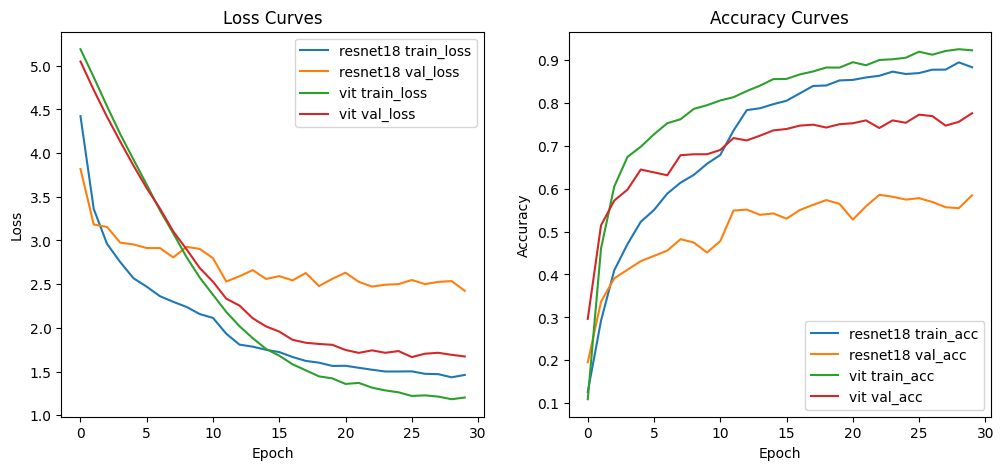

In [6]:

# =============================================================================
# 7. Compare Models
# =============================================================================
print("\n=== Model Comparison ===")
comparison_data = {
    "Model": list(test_results.keys()),
    "Test Accuracy": [f"{test_results[m]['acc']:.4f}" for m in test_results],
    "Test Top-5 Accuracy": [f"{test_results[m]['top5_acc']:.4f}" for m in test_results],
    "Macro F1-Score": [f"{test_results[m]['macro_f1']:.4f}" for m in test_results],
    "Total Train Time (s)": [f"{test_results[m]['train_time']:.1f}" for m in test_results]
}
print(pd.DataFrame(comparison_data).to_markdown(index=False))  # Requires import pandas as pd if needed

# Plot combined curves
plt.figure(figsize=(12, 5))
for name in all_history:
    plt.subplot(1, 2, 1)
    plt.plot(all_history[name]["train_loss"], label=f"{name} train_loss")
    plt.plot(all_history[name]["val_loss"], label=f"{name} val_loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(all_history[name]["train_acc"], label=f"{name} train_acc")
    plt.plot(all_history[name]["val_acc"], label=f"{name} val_acc")
    plt.title("Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()


=== Plotting Confusion Matrices ===


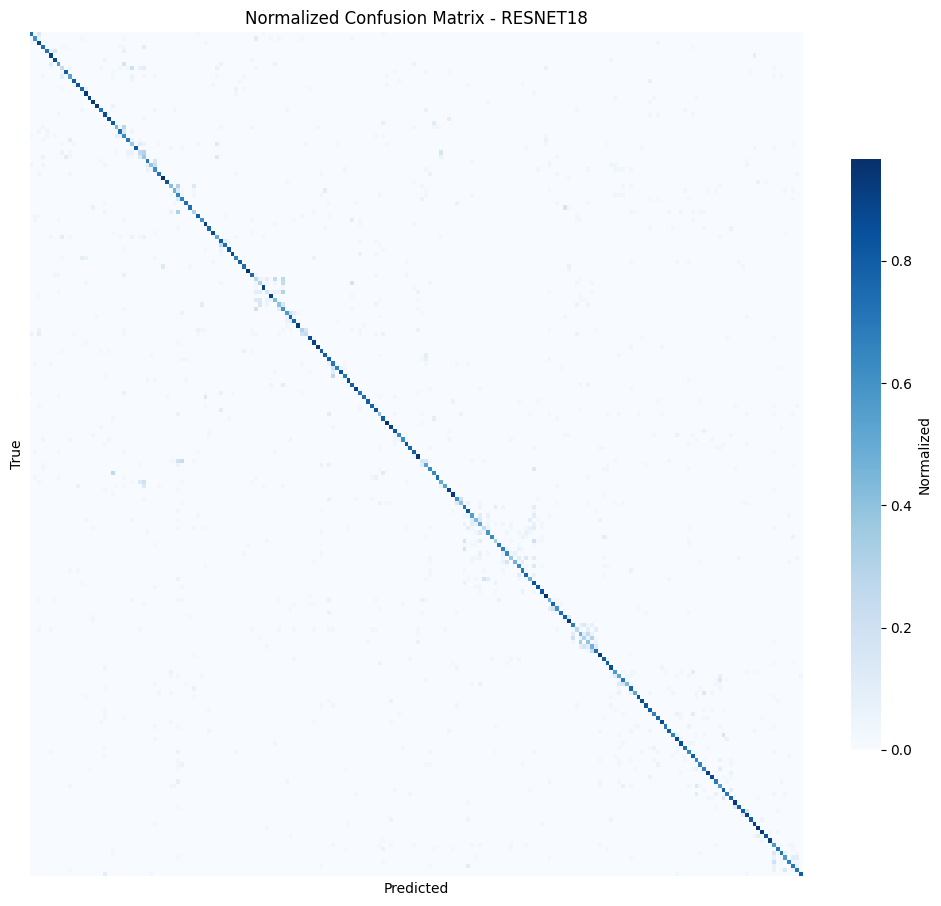

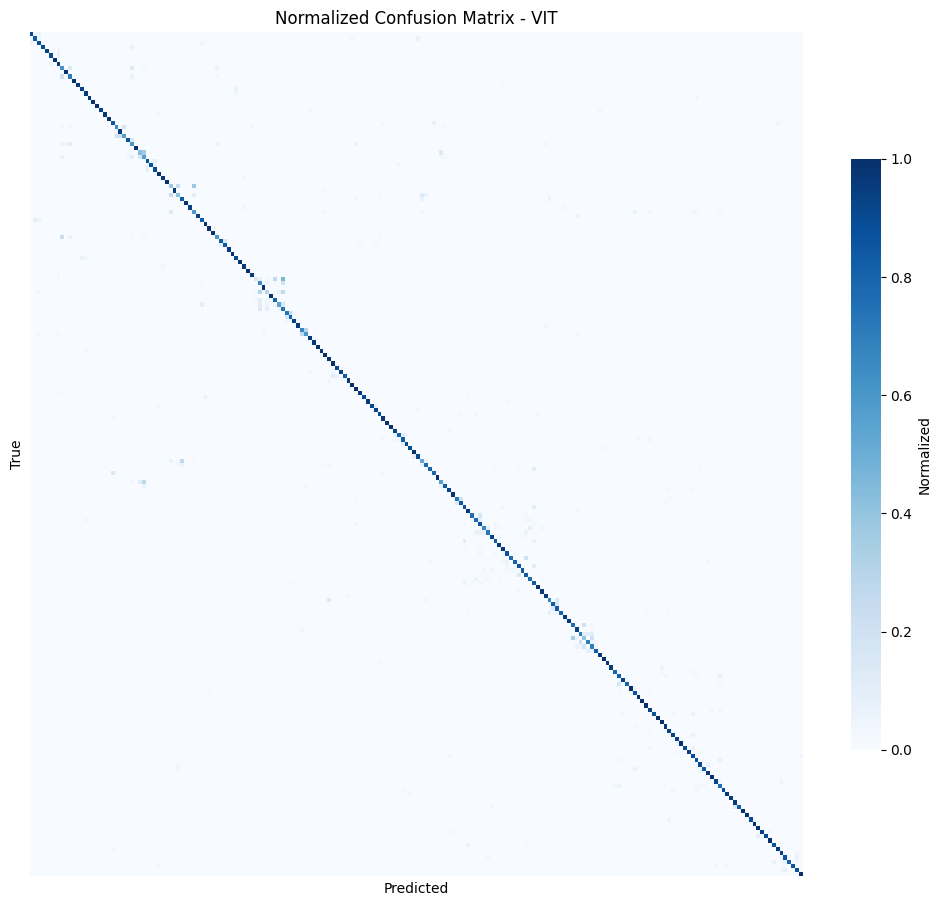

In [16]:
# =============================================================================
# 8. Plot Confusion Matrices for Both Models
# =============================================================================
print("\n=== Plotting Confusion Matrices ===")

for name in test_results:
    y_true = test_results[name]['labels']   # list or np.array of true labels
    y_pred = test_results[name]['preds']    # list or np.array of predicted labels

    # Compute Confusion Matrice (200x200)
    cm = confusion_matrix(y_true, y_pred)

    # Normalized (row-normalized to 1, easier to see error distribution)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)


    plt.figure(figsize=(10, 9))
    sns.heatmap(
        cm_normalized,
        cmap='Blues',
        annot=False,
        xticklabels=False,
        yticklabels=False,
        square=False,
        cbar_kws={'label': 'Normalized', 'shrink': 0.7}
    )
    plt.title(f'Normalized Confusion Matrix - {name.upper()}', fontsize=12)
    plt.ylabel('True', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.tight_layout(pad=0.5)
    plt.savefig(f'cm_{name}_small.png', dpi=200, bbox_inches='tight')
    plt.show()